# Bankrate Marketplace Case Study
## Optimizing Borrower–Lender Matching to Maximize Revenue Per Application

**Objective**

We want to improve how borrowers are matched to three lenders (A, B, and C) in order to:

- Increase approval likelihood for each borrower
- Maximize Revenue Per Application (RPA), defined as:

> RPA = P(approval | borrower, lender) × lender bounty per approval

**Key Questions**

1. What borrower attributes are most predictive of loan approval?
2. How do the three lenders differ in their approval behavior across FICO tiers?
3. Can we design a simple, explainable routing rule that improves RPA compared to the current matching?




##Load and Explore the Data

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os

os.chdir('/content/drive/My Drive/redventures')

Mounted at /content/drive


In [4]:
# Load the data
df = pd.read_excel('Pre-Super_Day_candidate_dataset__28candidate_29 (1).xlsx')

In [5]:
# View the first 5 rows
df.head(5)

,User ID,applications,Reason,Loan_Amount,FICO_score,Fico_Score_group,Employment_Status,Employment_Sector,Monthly_Gross_Income,Monthly_Housing_Payment,Ever_Bankrupt_or_Foreclose,Lender,Approved,bounty
0,00007820-89cb-4c1d-9940-eb270d605a35,1,cover_an_unexpected_cost,100000,669,fair,full_time,consumer_discretionary,5024,927,0,B,0,0
1,00012b55-514c-421e-9c76-3300abbc1134,1,credit_card_refinancing,70000,594,fair,full_time,information_technology,5764,1177,0,B,0,0
2,000157c1-b6a3-4c86-82c7-9ec1bda3799a,1,home_improvement,10000,596,fair,full_time,information_technology,4017,1487,0,A,0,0
3,00020400-efab-4b10-8812-2a0aaf774841,1,home_improvement,100000,642,fair,part_time,energy,3129,904,0,A,0,0
4,0002f737-0cda-48fb-91ed-533f3d0eab05,1,major_purchase,30000,642,fair,full_time,energy,4220,1620,0,A,0,0


In [9]:
# Summarize the data
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User ID                     100000 non-null  object
 1   applications                100000 non-null  int64 
 2   Reason                      100000 non-null  object
 3   Loan_Amount                 100000 non-null  int64 
 4   FICO_score                  100000 non-null  int64 
 5   Fico_Score_group            100000 non-null  object
 6   Employment_Status           100000 non-null  object
 7   Employment_Sector           93593 non-null   object
 8   Monthly_Gross_Income        100000 non-null  int64 
 9   Monthly_Housing_Payment     100000 non-null  int64 
 10  Ever_Bankrupt_or_Foreclose  100000 non-null  int64 
 11  Lender                      100000 non-null  object
 12  Approved                    100000 non-null  int64 
 13  bounty                      10

## 1. Basic Cleaning & Feature Engineering

Here we:
- Create a proxy DTI (Debt-to-Income) variable: monthly housing payment / monthly gross income  
- Enforce an ordered FICO group so plots and tables follow the correct credit tier order.


In [20]:
df = df.copy()

# DTI = monthly housing payment / monthly income
df["DTI"] = df["Monthly_Housing_Payment"] / df["Monthly_Gross_Income"]


# Enforce FICO group order
fico_order = ["poor", "fair", "good", "very_good", "excellent"]
df["Fico_Score_group"] = pd.Categorical(
    df["Fico_Score_group"],
    categories=fico_order,
    ordered=True
)

df[["Fico_Score_group", "DTI", "Approved"]].head()


,Fico_Score_group,DTI,Approved
0,fair,0.184514,0
1,fair,0.204198,0
2,fair,0.370177,0
3,fair,0.288910,0
4,fair,0.383886,0


## 2. Overall Approval & Key Predictors

First, I check the overall approval rate, then evaluate how strongly different variables separate approved vs declined borrowers.


In [6]:
overall_approval = df["Approved"].mean()
print("Overall approval rate:", round(overall_approval, 4))

# Approval by FICO group
approval_by_fico = df.groupby("Fico_Score_group")["Approved"].mean()
print("\nApproval by FICO group:")
print(approval_by_fico)

# Approval by employment status
approval_by_employment = df.groupby("Employment_Status")["Approved"].mean()
print("\nApproval by employment status:")
print(approval_by_employment)

# Approval by bankruptcy flag
approval_by_bankruptcy = df.groupby("Ever_Bankrupt_or_Foreclose")["Approved"].mean()
print("\nApproval by bankruptcy flag:")
print(approval_by_bankruptcy)

# Approval by loan reason
approval_by_reason = df.groupby("Reason")["Approved"].mean()
print("\nApproval by loan reason:")
print(approval_by_reason)


Overall approval rate: 0.1098

Approval by FICO group:
Fico_Score_group
poor         0.027849
fair         0.064373
good         0.180620
very_good    0.356527
excellent    0.457952
Name: Approved, dtype: float64

Approval by employment status:
Employment_Status
full_time     0.120711
part_time     0.081224
unemployed    0.054948
Name: Approved, dtype: float64

Approval by bankruptcy flag:
Ever_Bankrupt_or_Foreclose
0    0.111453
1    0.036064
Name: Approved, dtype: float64

Approval by loan reason:
Reason
cover_an_unexpected_cost    0.109307
credit_card_refinancing     0.112667
debt_conslidation           0.108935
home_improvement            0.109756
major_purchase              0.109530
other                       0.108138
Name: Approved, dtype: float64


/tmp/ipython-input-575409862.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  approval_by_fico = df.groupby("Fico_Score_group")["Approved"].mean()


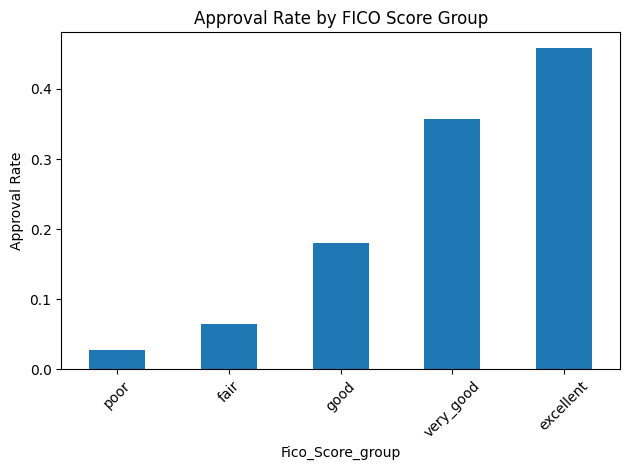

In [29]:
# Chart 1: Approval rate by FICO group
plt.figure()
(
    approval_by_fico
    .reindex(["poor", "fair", "good", "very_good", "excellent"])
    .plot(kind="bar")
)
plt.ylabel("Approval Rate")
plt.title("Approval Rate by FICO Score Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Approval by Loan Amount deciles
df["LoanAmount_decile"] = pd.qcut(df["Loan_Amount"], q=10, duplicates='drop')
df.groupby("LoanAmount_decile")["Approved"].mean()

/tmp/ipython-input-3629126918.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("LoanAmount_decile")["Approved"].mean()


,Approved
LoanAmount_decile,
"(4999.999, 10000.0]",0.128976
"(10000.0, 20000.0]",0.119939
"(20000.0, 30000.0]",0.117494
"(30000.0, 40000.0]",0.106387
"(40000.0, 50000.0]",0.109084
"(50000.0, 60000.0]",0.095552
"(60000.0, 80000.0]",0.095837
"(80000.0, 90000.0]",0.089698
"(90000.0, 100000.0]",0.092516


In [25]:
# Approval by Employment Sector
df.groupby("Employment_Sector")["Approved"].mean()

,Approved
Employment_Sector,
communication_services,0.095718
consumer_discretionary,0.084207
consumer_staples,0.096835
energy,0.106003
financials,0.132369
health_care,0.119729
industrials,0.117476
information_technology,0.122038
materials,0.108328


### Interpretation – FICO vs Other Predictors

- **FICO** is clearly the dominant predictor: approval rises smoothly from *poor* to *excellent*, with a spread of roughly 2–3% at the low end to ~45% at the high end.
- **Employment status** and **bankruptcy flag** are directionally sensible (full-time > part-time > unemployed; no-bankruptcy > bankruptcy), but with a smaller spread.
- **Loan reason, loan amount, and employment sector** have almost no impact on approval rates and appears to be non-predictive in this dataset.



## 3. Capacity Analysis: DTI (Decile-Based EDA)

To avoid arbitrary cutoffs, I use deciles of DTI and look at how approval rates change across the distribution.

This helps answer:
- Does approval decline monotonically with DTI?
- Where do the biggest risk transitions occur?


In [7]:
# DTI deciles
df["DTI_decile"] = pd.qcut(df["DTI"], q=10)

dti_decile_approval = df.groupby("DTI_decile")["Approved"].mean()
dti_decile_approval


/tmp/ipython-input-3208610123.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dti_decile_approval = df.groupby("DTI_decile")["Approved"].mean()


,Approved
DTI_decile,
"(0.016, 0.138]",0.2328
"(0.138, 0.181]",0.1501
"(0.181, 0.216]",0.1374
"(0.216, 0.25]",0.1148
"(0.25, 0.291]",0.0992
"(0.291, 0.342]",0.0958
"(0.342, 0.403]",0.0854
"(0.403, 0.482]",0.0665
"(0.482, 0.608]",0.0562


### DTI Interpretation

- Approval rates **decline as DTI rises**, with the steepest drops in the lower deciles (roughly below DTI ≈ 0.20).
- There are additional declines up to around DTI ≈ 0.35–0.50.
- Beyond about DTI ≈ 0.50, approval rates flatten at low levels (~5–6%), indicating a high-risk plateau.

DTI is **monotonic and directionally correct**, but the total spread in approval (17 points) is still smaller than FICO’s (~40+ points).


## 4. Lender Behavior Across FICO

Next, I analyze how each lender behaves across FICO groups:

- How many applications go to each lender?
- What is each lender's overall approval rate?
- How does approval change by FICO tier for each lender?



In [30]:
# Lender payouts defined in the case
payouts = {"A": 250, "B": 350, "C": 150}

# Approval rate per lender
approval_by_lender = df.groupby("Lender")["Approved"].mean()

# Expected revenue per application (RPA) per lender
rpa_by_lender = approval_by_lender * pd.Series(payouts)

# Applications per lender
apps_by_lender = df["Lender"].value_counts()

# Combine into a summary table
lender_summary = pd.DataFrame({
    "Applications": apps_by_lender,
    "Approval_Rate": approval_by_lender,
    "Payout": pd.Series(payouts),
    "RPA": rpa_by_lender
})

lender_summary


,Applications,Approval_Rate,Payout,RPA
A,55000,0.109655,250,27.413636
B,27500,0.071273,350,24.945455
C,17500,0.170571,150,25.585714


In [31]:
# Approval rate by FICO group and lender
fico_lender_approval = df.pivot_table(
    index="Fico_Score_group",
    columns="Lender",
    values="Approved",
    aggfunc="mean"
).reindex(fico_order)

fico_lender_approval


/tmp/ipython-input-746495425.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  fico_lender_approval = df.pivot_table(


Lender,A,B,C
Fico_Score_group,,,
poor,0.026274,0.000000,0.075524
fair,0.065689,0.015419,0.130186
good,0.179660,0.135946,0.260110
very_good,0.358491,0.297800,0.491803
excellent,0.443697,0.433333,0.546196


<Figure size 640x480 with 0 Axes>

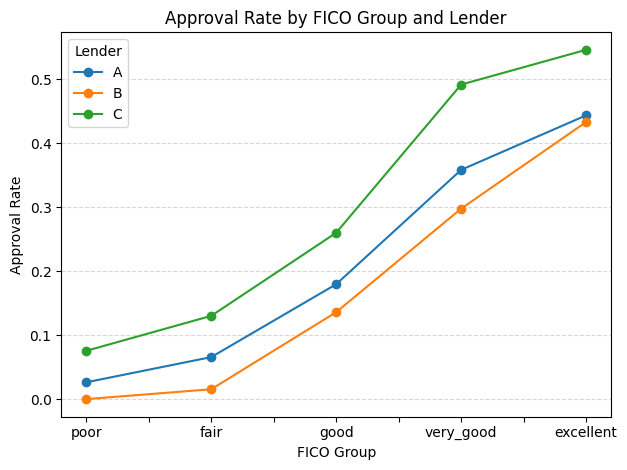

In [11]:
plt.figure()
fico_lender_approval.plot(marker="o")
plt.title("Approval Rate by FICO Group and Lender")
plt.ylabel("Approval Rate")
plt.xlabel("FICO Group")
plt.xticks(rotation=0)
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### Lender Behavior Interpretation

- **Lender C** has the highest approval rate in every FICO group, and especially stands out in poor and fair buckets.
- **Lender A** is in between C and B almost everywhere.
- **Lender B** is extremely strict in the lower FICO ranges (0% approvals for “poor”), and only becomes competitive at good+ FICO.


## 5. Revenue Per Application (RPA) Framework

Each lender pays a bounty per approval:

- Lender A → \$250  
- Lender B → \$350  
- Lender C → \$150  

For a given borrower–lender combination:

> **Expected RPA = P(approval | FICO, lender) × bounty**

I will:

1. Compute expected RPA by FICO × lender.  
2. Propose a simple FICO-based routing rule.  
3. Compare current routing vs rule-based routing on expected RPA.


In [12]:
# Bounties per approval
bounty_map = {"A": 250, "B": 350, "C": 150}

# Approval rate by FICO group and lender (already computed)
fico_lender_approval = fico_lender_approval

# Expected RPA by FICO × lender
ev_by_fico_lender = fico_lender_approval.copy()
for lender, bounty in bounty_map.items():
    ev_by_fico_lender[lender] = ev_by_fico_lender[lender] * bounty

print("Expected RPA by FICO group and lender:")
print(ev_by_fico_lender)

# Tidy table for merging later
ev_table = (
    ev_by_fico_lender
    .reset_index()
    .melt(id_vars="Fico_Score_group", var_name="Lender", value_name="Expected_RPA")
)
ev_table.head()


Expected RPA by FICO group and lender:
Lender                     A           B          C
Fico_Score_group                                   
poor                6.568433    0.000000  11.328588
fair               16.422145    5.396553  19.527897
good               44.915042   47.581081  39.016544
very_good          89.622642  104.230118  73.770492
excellent         110.924370  151.666667  81.929348


,Fico_Score_group,Lender,Expected_RPA
0,poor,A,6.568433
1,fair,A,16.422145
2,good,A,44.915042
3,very_good,A,89.622642
4,excellent,A,110.924370


<Figure size 640x480 with 0 Axes>

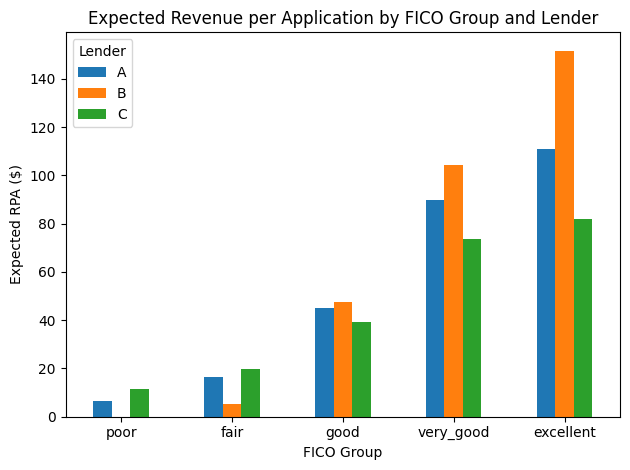

In [13]:
plt.figure()
ev_by_fico_lender.plot(kind="bar")
plt.title("Expected Revenue per Application by FICO Group and Lender")
plt.ylabel("Expected RPA ($)")
plt.xlabel("FICO Group")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Interpretation – Expected RPA

- For low FICO tiers, **Lender C** tends to have the highest expected RPA because it is the only one approving those segments at non-trivial rates.
- For mid-FICO tiers, **Lender A** often has a strong RPA. A is a good default lender, especially when B or C are suboptimal.
- For high FICO tiers, **Lender B** has both high approval rates and the largest bounty, resulting in the highest expected RPA.



## 6. Simple FICO-Based Routing Rule

Based on FICO × lender behavior and expected RPA, I define the following **rule-based lender assignment**:

- **Poor / Fair → Lender C**
- **Good → Lender A**
- **Very Good / Excellent → Lender B**

Note: B outperforms A for "good" borrowers. However, real-time routing should balance approvals with lender relationships. Lender B is more strict for lower FICO groups while lender A is more lenient and more appropriate for this segment.




In [14]:
# Map FICO group -> lender according to the rule
fico_to_lender = {
    "poor": "C",
    "fair": "C",
    "good": "A",
    "very_good": "B",
    "excellent": "B",
}

df["Lender_rule_simple"] = df["Fico_Score_group"].map(fico_to_lender)

df[["Fico_Score_group", "Lender", "Lender_rule_simple"]].head()


,Fico_Score_group,Lender,Lender_rule_simple
0,fair,B,C
1,fair,B,C
2,fair,A,C
3,fair,A,C
4,fair,A,C


In [16]:
# Expected RPA under current lender assignment
df_current = df.merge(
    ev_table,
    how="left",
    left_on=["Fico_Score_group", "Lender"],
    right_on=["Fico_Score_group", "Lender"],
)
df_current = df_current.rename(columns={"Expected_RPA": "RPA_expected_current"})

# Expected RPA under rule-based lender assignment
df_rule = df_current.merge(
    ev_table,
    how="left",
    left_on=["Fico_Score_group", "Lender_rule_simple"],
    right_on=["Fico_Score_group", "Lender"],
    suffixes=("", "_rule")
)
df_rule = df_rule.rename(columns={"Expected_RPA": "RPA_expected_rule"})

df_result = df_rule

# Summary metrics
rpa_current = df_result["RPA_expected_current"].mean()
rpa_rule = df_result["RPA_expected_rule"].mean()
uplift_per_app = rpa_rule - rpa_current
uplift_pct = uplift_per_app / rpa_current if rpa_current != 0 else np.nan
total_apps = len(df_result)
total_uplift = uplift_per_app * total_apps

print("Expected RPA (current):", round(rpa_current, 2))
print("Expected RPA (rule):   ", round(rpa_rule, 2))
print("Uplift per application:", round(uplift_per_app, 2))
print("Uplift (%):            ", round(uplift_pct * 100, 2), "%")
print("Total uplift (dataset):", round(total_uplift, 2))

# Lender distribution summary under rule
print("\nLender distribution under FICO rule:")
print(df_result["Lender_rule_simple"].value_counts())


Expected RPA (current): 26.41
Expected RPA (rule):    31.45
Uplift per application: 5.04
Uplift (%):             19.07 %
Total uplift (dataset): 503831.91

Lender distribution under FICO rule:
Lender_rule_simple
C    64950
A    27760
B     7290
Name: count, dtype: int64


## 7. Conclusions & Next Steps

**Key findings**

- FICO is the dominant driver of approval, with a much larger effect size than DTI, employment status, or bankruptcy history.
- Lenders show clear, predictable patterns by FICO tier:
  - Lender C → lower-FICO
  - Lender A → mid-FICO
  - Lender B → high-FICO
- A simple FICO-based routing rule aligns well with actual lender behavior and meaningfully improves expected RPA compared to current routing.
- Final routing rule: poor/fair → C, good → A, very_good/excellent → B. This balances revenue uplift with approval rates and marketplace stability.

**Tradeoffs**
- I selected good → A intentionally even though B has slightly higher Expected RPA for the segment.
The tardeoff is:
  - A provides higher approval rates and better borrower experience
  - A maintains healthier lender volume balance
- I chose a simple rule-based approach over ML due to:
  - Strongly deterministic FICO patterns
  - Heavy class imbalance
  - The need for interpretability and easy deployment
- DTI was used for EDA, but not included in the routing rule.

**If I had more time**

- Refine edge cases near FICO band boundaries using DTI or other indicators as secondary checks.
- Explore fairness, access, and potential disparate impact, especially if the rule were adapted for production.
- Evaluate whether a blended routing strategy (e.g., distributing “good” borrowers between A and B) improves lender balance while preserving revenue uplift.

